# Face Detection and Recognition CNN Models

Author: Luca Franceschi (u199149)

In this notebook we will try to construct two CNN models, one for face boundary detection and another for face recognition. The intention for the Coding Challenge 3 is to: with each image first detect if there is a face or not, in case there is, detect the boundaries. Then we can crop the image with the calculated boundaries and pass it to the recognition model to be able to recognize if the face exists in the dataset or is an impostor.

In [1]:
import os
import cv2
import dlib
import torch
import scipy.io
import torch.jit
import numpy as np
from torch import nn
import torch.optim as optim
from matplotlib import ticker
from torchinfo import summary
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.patches as patches
from torch.utils.data import random_split
from facenet_pytorch.models.mtcnn import MTCNN
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import get_image_size

In [2]:
# Hyperparameters
lr = 0.0001                 # Learning rate
epochs1 = 45                # Total number of epochs
epochs2 = 50
batch_size = 32             # The sizes in which the dataset is split to feed the networks
det_resized = (224, 224)    # The normalized size of the images in the detection model
rec_resized = det_resized   # The normalized size of the images in the recognition model
prediction_threshold = 0.0  # Prediction threshold used in the recognition predict function

# Other parameters
epoch_step = 1              # Frequency in which epoch losses are printed on training
images_path = './TRAINING/' # Relativ# train_mean, train_std = compute_mean_std(det_train_data)e path to the training dataset
target_matrix_path = ''     # Relative path to the "AGC_Challenge3_Training.mat" file
identities = 80

In [3]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the data

### The target matrix

When loading the matrix we can import either the boundaries or the identity. 
- For the detection network we will import the Image name along with the boundaries. In case there is a face (or more) the first position in the boundaries will be the amount of faces in that image. In case there is no faces, that parameter will be 0 and the boundaries will be a "padding" of zeros. The imported data in this case will look like: ```[name, [#faces, x0, y0, x1, y1]]```, very similar as in previous labs. In case there are more than one face the first one in the matrix will be considered.
- For the recognition network we will import the image name along with the id and its boundaries. If the id is -1 it is imported as 0 to fix some out of bounds error. This is corrected in the output of the model and is transparent to the user.

In [4]:
def load_data(labels_path, labels_wanted='boundaries', name='AGC_Challenge3_TRAINING'):
    mat = scipy.io.loadmat(labels_path)[name]
    if len(mat) == 1:
        mat = scipy.io.loadmat(labels_path)[name][0]
    data = []
    # counter = 0
    # impostors = 0
    for entry in mat:
        key = entry[1][0]
        if (len(entry[2]) > 0):
            boundary = np.array(entry[2][0], dtype=np.int32)
            if (labels_wanted == 'boundaries'):
                data.append([key, boundary])
            elif (labels_wanted == 'identity'):
                if (entry[0][0][0] == -1):
                    # if (impostors < counter / identities):
                    data.append([key, 0, boundary])
                        # impostors += 1
                else:
                    data.append([key, entry[0][0][0], boundary])
                    # counter += 1

    return data

### Offline data augmentation

The steps that I followed are:
1. Group the images by identity and store them in a directory named grouping
2. For each identity, identify the name from the id and get new images from the internet until each one has 20 more or less (manually)
3. Rename all images so they are in the format (augm_image_738.png) (manually, maybe could've automated this)
4. Load all new images into the training directory
5. Build a preliminary matrix that holds automated targets (almost all wrong)
6. Hand-annotate the images (almost all were done manually)
7. Test that all are correctly annotated
8. Notice that the automated images are all incorrect and hoping to die soon due to a heart stroke
9. Isolate the wrong annotated images (all the automated ones) and annotate manually

The following chunk of code is all commented because the full process is not automated, these are the only steps that can be automated.

In [5]:
# step 1

# for entry in recognition_data:
#     with Image.open(images_path + entry[0]) as image:
#         dir = './grouping/' + str(entry[1]) + '/'
#         if not os.path.isdir(dir):
#             os.makedirs(dir)
#         image.save(dir + entry[0])

In [6]:
# step 4

# for folder_id in os.listdir('./grouping'):
#     path = './grouping/' + folder_id
#     for filename in os.listdir(path):
#         if filename[:4] == 'augm':
#             with Image.open(path + '/' + filename) as image:
#                 image.save(images_path + '/' + filename)

In [7]:
# step 5

# path_to_cv2_model = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
# cv2_detector = cv2.CascadeClassifier(path_to_cv2_model)

# def get_boundary_viola_jones(image, detector):
#     output = cv2_detector.detectMultiScale(  np.array(image),
#                                         scaleFactor=1.1,
#                                         minNeighbors=4,
#                                         minSize=(20, 20),
#                                         flags=cv2.CASCADE_SCALE_IMAGE)
#     if len(output) == 1:
#         output = output[0]
    
#     if len(output) == 4:
#         return [output[0], output[1], output[2]-output[0], output[3]-output[1]]
#     return []

# def augmentate_data(grouped_dataset):
#     # mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
#     # print(type(mat))
#     new_mat = []
#     for folder_id in os.listdir(grouped_dataset):
#         for filename in os.listdir(grouped_dataset + '/' + folder_id):
#             if filename[:4] == 'augm':
#                 # mat.append()
#                 # print(filename)
#                 id = np.array([[folder_id]], dtype=np.int16)
#                 name = np.array([filename])

#                 with Image.open(grouped_dataset + '/' + folder_id + '/' + filename) as image:
#                     output = get_boundary_viola_jones(image, cv2_detector)
                    
#                     if len(output) == 0:
#                         print(filename)
                        
#                     boundaries = np.array(output, dtype=np.uint16)
#                     new_entry = (id, name, boundaries)
#                     new_mat.append(new_entry)
#     return new_mat

# augmented_data = augmentate_data('./grouping)
# scipy.io.savemat('augmented.mat', {'augmented':augmentated_data})

In [8]:
# steps 7 and 8

# testing_data = load_data(target_matrix_path + 'augmented_training.mat', 'identity', name='augmented')

# for entry in testing_data:
#     if entry[2][0] > entry[2][2]:
#         tmp = entry[2][0].copy()
#         entry[2][0] = entry[2][2].copy()
#         entry[2][2] = tmp

#     if entry[2][1] > entry[2][3]:
#         tmp = entry[2][1].copy()
#         entry[2][1] = entry[2][3].copy()
#         entry[2][3] = tmp

#     tmp = entry[0].copy()
#     entry[0] = entry[1].copy()
#     entry[1] = tmp

# scipy.io.savemat('augmented_training2.mat', {'augmented':testing_data})

In [9]:
# testing_data = load_data(target_matrix_path + 'augmented_training2.mat', 'identity', name='augmented')

# for entry in testing_data:
#     with Image.open(images_path + entry[0]) as image:
#         draw = ImageDraw.Draw(image)
#         print(entry[0], entry[2])
#         draw.rectangle((entry[2][0], entry[2][1], entry[2][2], entry[2][3]), outline='red', width=5)
#         image.save('./testing/boundaries/' + entry[0])

In [10]:
# testing_data = load_data(target_matrix_path + 'augmented_training2.mat', 'identity', name='augmented')

# for entry in testing_data:
#     if entry[0] in os.listdir('./testing/boundaries/wrong'):
#         entry[2] = []

#     tmp = entry[0].copy()
#     entry[0] = entry[1].copy()
#     entry[1] = tmp

# scipy.io.savemat('augmented_training3.mat', {'augmented':testing_data})

In [11]:
# wrong = os.listdir('./testing/boundaries/wrong')
# testing_data = load_data(target_matrix_path + 'augmented_training2.mat', 'identity', name='augmented')
# for entry in testing_data:
#     entry[2][2] =  entry[2][2] - entry[2][0]
#     entry[2][3] =  entry[2][3] - entry[2][1]

#     if entry[0] in wrong:
#         entry[2] = []

#     tmp = entry[0].copy()
#     entry[0] = entry[1].copy()
#     entry[1] = tmp

# scipy.io.savemat('augm_widths_filling.mat', {'augmented':testing_data})

In [12]:
# augmented_data_widths = load_data(target_matrix_path + 'augmented_training_widths.mat', 'identity', name='augmented')

# for entry in augmented_data_widths:
#     entry[2][2] =  entry[2][2] + entry[2][0]
#     entry[2][3] =  entry[2][3] + entry[2][1]

#     tmp = entry[0].copy()
#     entry[0] = entry[1].copy()
#     entry[1] = tmp

# scipy.io.savemat('augmented_training.mat', {'augmented':augmented_data_widths})

### Loading the base and augmented dataset and merging them

Now that we have the base and augmented datasets ready we can load them as usual

In [13]:
detection_base_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
recognition_base_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat', 'identity')

detection_augmented_data = load_data(target_matrix_path + 'augmented_training.mat', name='augmented')
recognition_augmented_data = load_data(target_matrix_path + 'augmented_training.mat', 'identity', name='augmented')

detection_data = detection_augmented_data # + detection_base_data
recognition_data = recognition_base_data + recognition_augmented_data

### Computing the mean and standard deviation

In [14]:
def compute_mean_std(dataset):
    image_count = len(dataset)
    images = np.zeros((image_count, rec_resized[0], rec_resized[1], 3))
    for i, (image_path, _) in enumerate(dataset):
        with Image.open(images_path + image_path) as image:
            image = image.resize(det_resized)
            image = image.convert('RGB')
            image_array = np.array(image)
            images[i] = image_array

    mean = np.mean(images, axis=(0, 1, 2)) / 255.0
    std_dev = np.std(images, axis=(0, 1, 2)) / 255.0

    return mean, std_dev

In [15]:
m, s = compute_mean_std(detection_data)

# data_mean = [0.485, 0.456, 0.406]
# data_std = [0.229, 0.224, 0.225]

data_mean = m
data_std = s

print(data_mean, data_std)

[0.45820965 0.4014416  0.38912803] [0.32574846 0.29894599 0.30020403]


## The Transforms

In [16]:
det_tr_transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(det_resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=data_mean, std=data_std)
])

det_base_transform = transforms.Compose([
    transforms.Resize(det_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_tr_transform = transforms.Compose([
    transforms.RandomResizedCrop(rec_resized),
    transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(180),
    transforms.RandomGrayscale(0.2),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.RandomAffine(90),
    transforms.AutoAugment(),
    ## scaling shearing affine
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_val_transform = transforms.Compose([
    transforms.Resize(rec_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

### Early stopper

In [17]:
class EarlyStopper: # used in classification problem
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
        return self.counter

## The Convolutional Neural Network Class

In [18]:
class CNN(nn.Module):
    def __init__(self, cnn_layers, fc_layers, type):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = cnn_layers
        self.fc_layers = fc_layers
        self.cnn_type = type

    def forward(self, data):
        output = self.cnn_layers(data)
        output = self.flatten(output) # before linear layer !!!
        output = self.fc_layers(output)
        return output

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer):
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = self.forward(batch_data)
            
            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)

            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

    def evaluate(self, validation_data, loss_fn):
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)

            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)

            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            if self.cnn_type == 'detection':
                test_image = det_base_transform(test_image)
                # test_image = torch.tensor(test_image, dtype=torch.float32)
                output = self.forward(test_image.unsqueeze(0))[0]
                # print(output)
                # output = [output[0], output[1]*w/det_resized[0], output[2]*h/det_resized[1], output[3]*w/det_resized[0], output[4]*h/det_resized[1]]
                output = [output[0]*w/det_resized[0], output[1]*h/det_resized[1], output[2]*w/det_resized[0], output[3]*h/det_resized[1]]
                # print(output)
                return output
            elif self.cnn_type == 'recognition':
                test_image = rec_val_transform(test_image)
                output = self.forward(test_image.unsqueeze(0))
                output = torch.softmax(output, 1)
                prediction = np.argmax(output)
                if prediction == 0 or output[0][prediction] < prediction_threshold:
                    return -1
                return int(prediction)

    def training_loop(self, training_loader, val_loader, epochs, loss_fn, lr):
        tr_losses = []
        val_losses = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        best_weights = self.state_dict().copy()
        if self.cnn_type == 'detection':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs')

        early_stopper = EarlyStopper(patience=3, min_delta=0.01)

        for epoch in range(epochs):
            tr_losses.append(self.fit(training_loader, loss_fn, optimizer))
            loss = self.evaluate(val_loader, loss_fn)
            val_losses.append(loss)
            if self.cnn_type == 'detection':
                scheduler.step(loss)

            stopper = early_stopper.early_stop(loss)
            if stopper == 0:
                best_weights = self.state_dict().copy()
            elif stopper > early_stopper.patience:
                self.load_state_dict(best_weights)
                break

            if epoch % epoch_step == 0:
                print(f'Epoch {epoch} has loss {val_losses[epoch]}')
        
        return tr_losses, val_losses

## The Detection Model

### DataLoader

In [19]:
class DetectionData(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            # label = [label[0], label[1]/w*det_resized[0], label[2]/h*det_resized[1], label[3]/w*det_resized[0], label[4]/h*det_resized[1]]
            label = [label[0]/w*det_resized[0], label[1]/h*det_resized[1], label[2]/w*det_resized[0], label[3]/h*det_resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [20]:
det_train_data, det_val_data, det_test_data = random_split(detection_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset = DetectionData(det_train_data, det_tr_transform)
val_dataset = DetectionData(det_val_data, det_base_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### Layers

In [21]:
detection_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
detection_fc_layers = nn.Sequential(
    # nn.Dropout(0.3),
    nn.Linear(25088, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 4)
)

### Training

In [22]:
detection = CNN(detection_cnn_layers, detection_fc_layers, 'detection').to(device)
summary(detection, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 4]                   --
├─Sequential: 1-1                        [32, 128, 14, 14]         --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 224, 224]        32
│    └─ReLU: 2-3                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 16, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 32, 112, 112]        4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 112, 112]        64
│    └─ReLU: 2-7                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 32, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 64, 56, 56]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 56, 56]          128
│    └─ReLU: 2-11                        [32, 64, 56, 56]          --
│    └

In [23]:
# detection.load_state_dict(torch.load('detection_model.pt'))

In [24]:
print(sum(p.numel() for p in detection.parameters()))

900900


In [25]:
loss = nn.MSELoss()
det_tr_losses, det_val_losses = detection.training_loop(train_loader, val_loader, epochs1, loss, lr)

Epoch 0 has loss 10345.944010416666
Epoch 1 has loss 6138.09912109375
Epoch 2 has loss 3512.3972981770835
Epoch 3 has loss 2164.7264404296875
Epoch 4 has loss 1429.9055582682292
Epoch 5 has loss 1440.3714599609375
Epoch 6 has loss 1040.1429036458333
Epoch 7 has loss 796.5927124023438
Epoch 8 has loss 872.6247355143229
Epoch 9 has loss 788.8437093098959
Epoch 10 has loss 662.9183553059896
Epoch 11 has loss 636.3057454427084
Epoch 12 has loss 683.9067789713541
Epoch 13 has loss 556.9001770019531
Epoch 14 has loss 634.5297444661459
Epoch 15 has loss 718.1743977864584
Epoch 16 has loss 566.2873942057291


### Plots

In [26]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

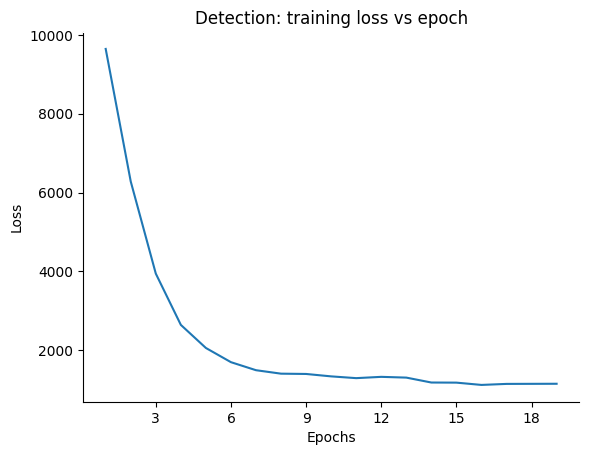

In [27]:
loss_epoch_plot(det_tr_losses, "Detection: training loss vs epoch")

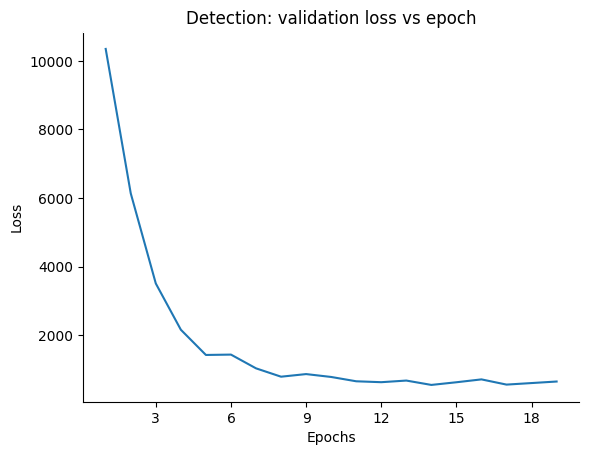

In [28]:
loss_epoch_plot(det_val_losses, "Detection: validation loss vs epoch")

### Testing

[334 130 480 298]


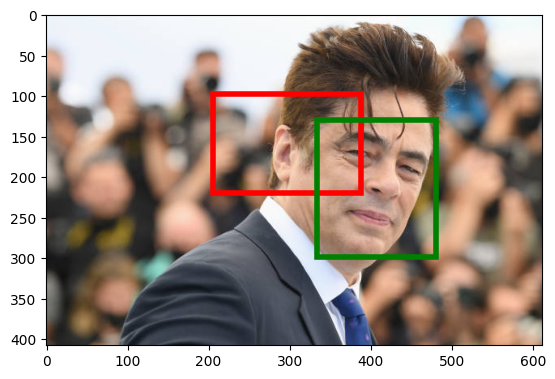

[197  98 323 253]


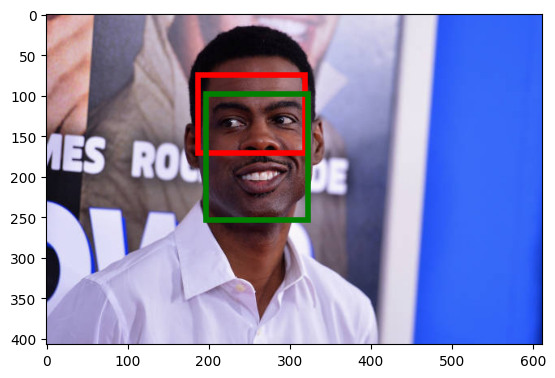

[ 94 179 315 468]


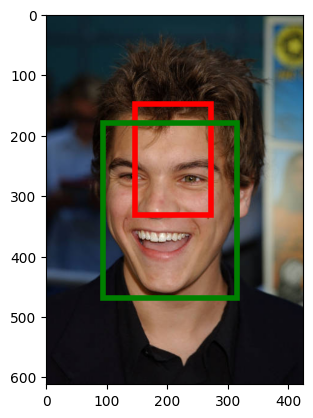

[191  43 239  92]


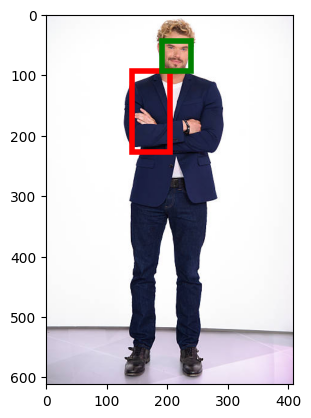

[144 138 338 359]


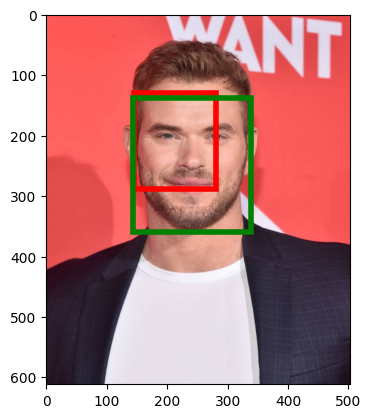

[238  89 301 171]


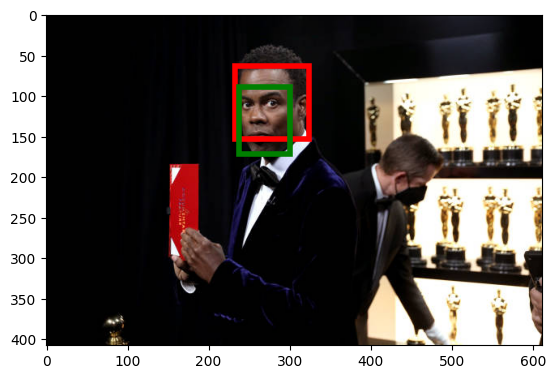

[152  89 257 196]


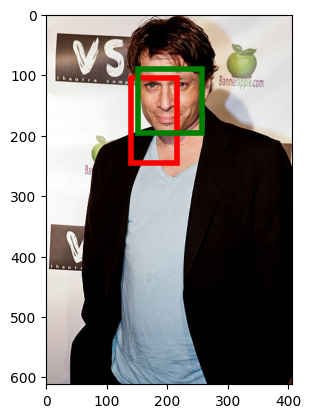

In [ ]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        print(target)
        output = detection.predict(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1],
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1],
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(pred_fb)
        ax.add_patch(fb)
        plt.show()

### Saving

In [30]:
torch.save(detection.state_dict(), 'detection_model.pt')

## The Detection Model 2 (Viola-Jones)

In [31]:
path_to_cv2_model = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
cv2_detector = cv2.CascadeClassifier(path_to_cv2_model)
#concatenado de modelos

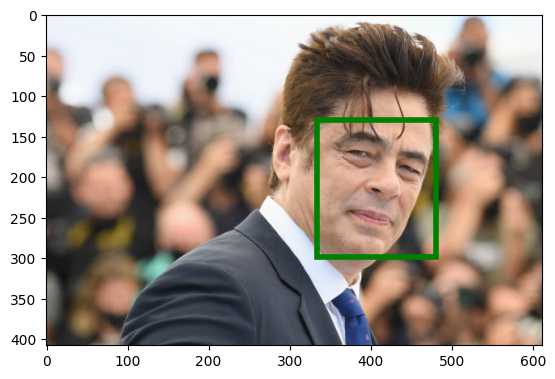

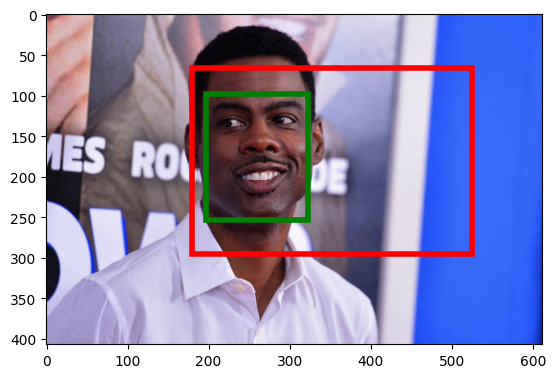

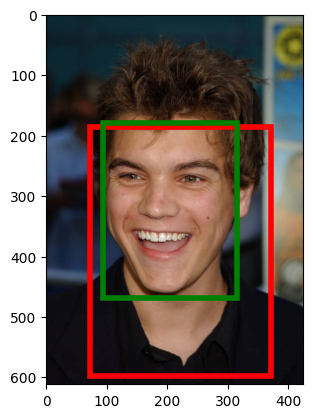

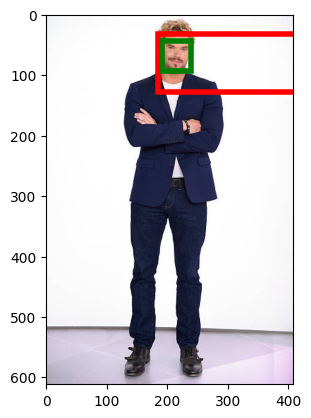

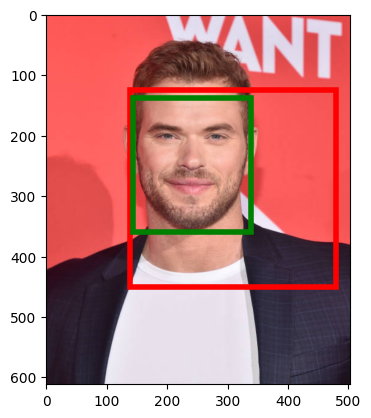

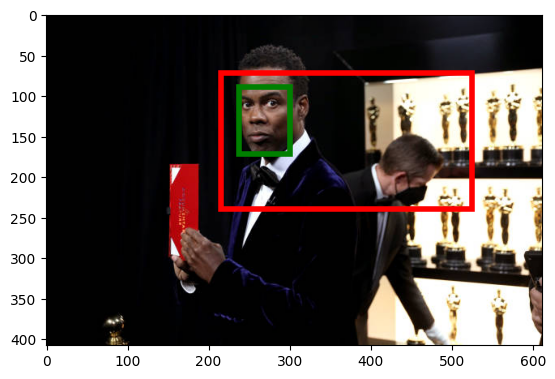

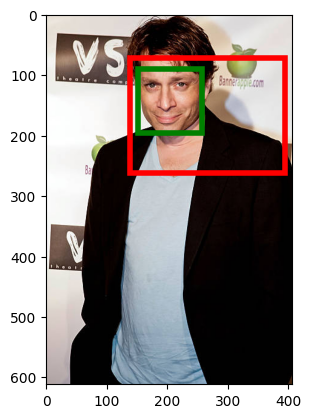

In [32]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        
        output = cv2_detector.detectMultiScale(  np.array(image),
                                        scaleFactor=1.25,
                                        minNeighbors=4,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
        if len(output) == 1:
            output = output[0]
        
        if len(output) == 4:
            pred_fb = patches.Rectangle((output[0], output[1]), output[2]+output[0], output[3]+output[1],
                               linewidth=4, edgecolor='red', facecolor='none')
            ax.add_patch(pred_fb)
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1],
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(fb)
        plt.show()

## The detection model 3 (Dlib MTCNN)

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=False, device=device, select_largest=True)

def mtcnn_detect(img: np.ndarray):
    boxes, probs = mtcnn.detect(img)
    for box in boxes:
        x_left = int(min(box[0], box[2]))
        x_right = int(max(box[0], box[2]))
        y_left = int(min(box[1], box[3]))
        y_right = int(max(box[1], box[3]))

        return (x_left, y_left, x_right, y_right)

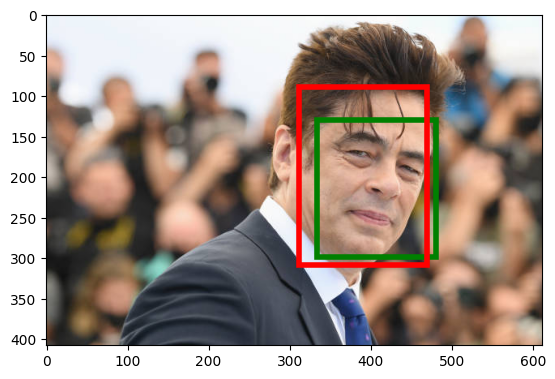

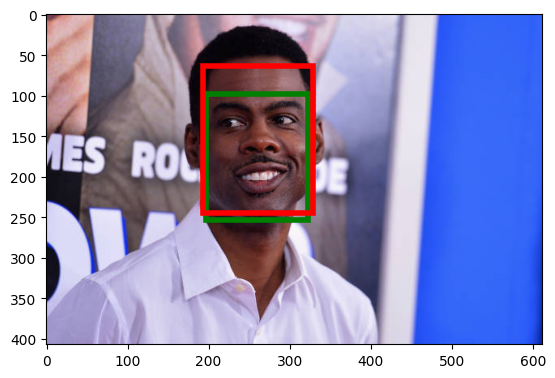

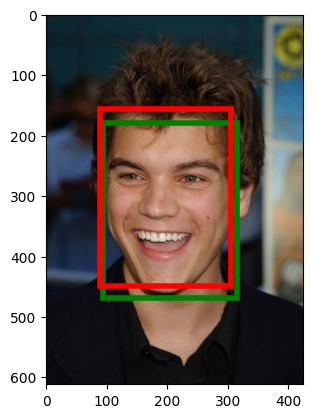

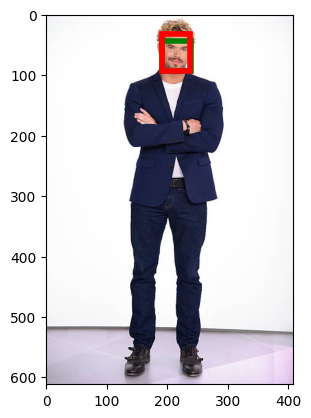

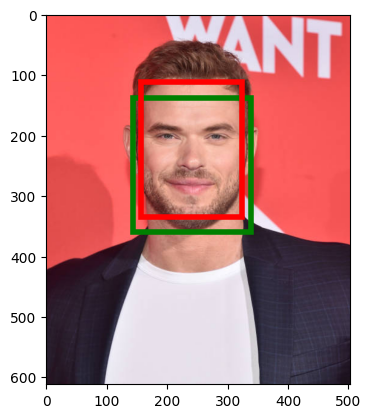

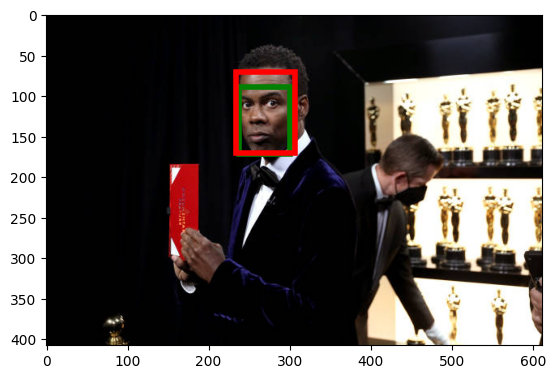

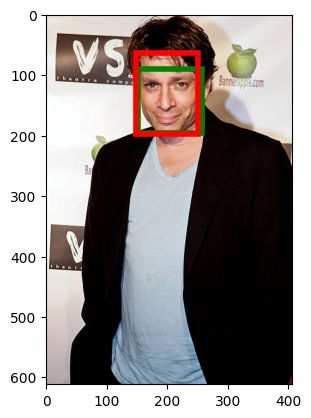

In [34]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name).convert('RGB') as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        output = mtcnn_detect(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1],
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1],
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(fb)
        ax.add_patch(pred_fb)
        plt.show()

## The Recognition model

### DataLoader

In [42]:
class RecognitionData(Dataset):
    # the data is in the form [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, id, boundary = self.data[idx]
        with Image.open(images_path + image_name) as image:
            image = image.convert('RGB')
            image = image.crop(boundary)
            if self.transform:
                image = self.transform(image)
            id = torch.tensor(id, dtype=torch.float32)
            return image, id

In [43]:
rec_train_data, rec_val_data, rec_test_data = random_split(recognition_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset2 = RecognitionData(rec_train_data, rec_tr_transform)
val_dataset2 = RecognitionData(rec_val_data, rec_val_transform)

# sampler = WeightedRandomSampler(class_weights_inv, len(train_dataset2), replacement=True)
# train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, sampler=sampler)
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

### Class weighting

In [44]:
def get_class_weights(data, classes):
    ids = [entry[1] for entry in data]
    ids = np.bincount(ids)
    fig, ax = plt.subplots()
    # ax.hist(ids, identities)
    plt.bar(range(identities+1), ids)
    plt.title('Class counts histogram')
    plt.xlabel('Identity')
    plt.ylabel('Count')
    # plt.yscale('log', base=2)
    plt.show()
    # counters = np.bincount(ids)
    sum = np.sum(ids)
    print('Total images:', sum)
    return sum / (classes * ids)

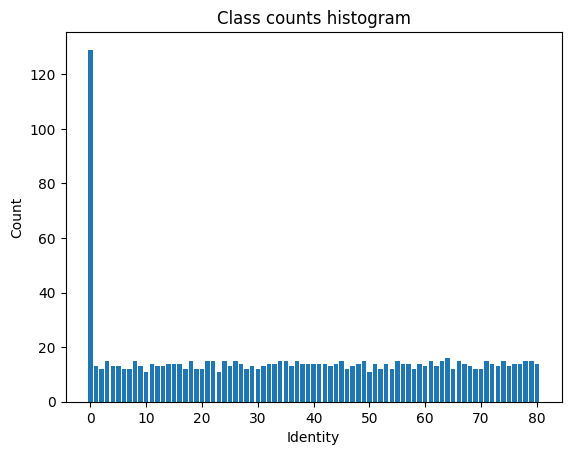

Total images: 1215
Class weights: tensor([0.1177, 1.1683, 1.2656, 1.0125, 1.1683, 1.1683, 1.2656, 1.2656, 1.0125,
        1.1683, 1.3807, 1.0848, 1.1683, 1.1683, 1.0848, 1.0848, 1.0848, 1.2656,
        1.0125, 1.2656, 1.2656, 1.0125, 1.0125, 1.3807, 1.0125, 1.1683, 1.0125,
        1.0848, 1.2656, 1.1683, 1.2656, 1.1683, 1.0848, 1.0848, 1.0125, 1.0125,
        1.1683, 1.0125, 1.0848, 1.0848, 1.0848, 1.0848, 1.0848, 1.1683, 1.0848,
        1.0125, 1.2656, 1.1683, 1.0848, 1.0125, 1.3807, 1.0848, 1.2656, 1.0848,
        1.2656, 1.0125, 1.0848, 1.0848, 1.2656, 1.0848, 1.1683, 1.0125, 1.1683,
        1.0125, 0.9492, 1.2656, 1.0125, 1.0848, 1.1683, 1.2656, 1.2656, 1.0125,
        1.0848, 1.1683, 1.0125, 1.1683, 1.0848, 1.0848, 1.0125, 1.0125, 1.0848])


In [45]:
weights = get_class_weights(rec_train_data, identities) # Used for balancing classification problem
class_weights = torch.FloatTensor(weights)
print('Class weights:', class_weights)

### Layers

In [61]:
'''recognition_cnn_layers = nn.Sequential( # prueba al revés (empezar con numero alto de canales e ir reduciendo hasta 64 64 32 32 16 16)
    #64 64 128 128
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),                                                 ## SACRIFICAR ???
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # prueba de dejarlo en 1 el stride (antes 2)

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2)                   ## 8X8 DE MINIMO A 12X12

    # adaptivemaxpooling prueba
)'''

recognition_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=4, stride=3)
)
recognition_fc_layers = nn.Sequential(
    # nn.Dropout(0.2),# prueba de quitar dropout
    nn.Linear(8192, 80), # image size que no sea pequeño pero <12x12
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(80, 81), # 1-80 are ids + (-1) are 81 identities
)

### Training

In [67]:
recognition = CNN(recognition_cnn_layers, recognition_fc_layers, 'recognition').to(device)
summary(recognition, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 81]                  --
├─Sequential: 1-1                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 64, 111, 111]        --
│    └─Conv2d: 2-5                       [32, 64, 111, 111]        36,928
│    └─BatchNorm2d: 2-6                  [32, 64, 111, 111]        128
│    └─ReLU: 2-7                         [32, 64, 111, 111]        --
│    └─MaxPool2d: 2-8                    [32, 64, 55, 55]          --
│    └─Conv2d: 2-9                       [32, 128, 55, 55]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 55, 55]         256
│    └─ReLU: 2-11                        [32, 128, 55, 55]         --
│

In [68]:
# recognition.load_state_dict(torch.load('recognition_model.pt'))

In [69]:
print(sum(p.numel() for p in recognition.parameters()))

922929


In [70]:
loss2 = nn.CrossEntropyLoss(class_weights)
rec_tr_losses, rec_val_losses = recognition.training_loop(train_loader2, val_loader2, epochs2, loss2, lr)

Epoch 0 has loss 4.39550552368164
Epoch 1 has loss 4.3954980850219725
Epoch 2 has loss 4.395503234863281
Epoch 3 has loss 4.395504188537598
Epoch 4 has loss 4.395485591888428
Epoch 5 has loss 4.395526599884033
Epoch 6 has loss 4.395490264892578
Epoch 7 has loss 4.395493698120117
Epoch 8 has loss 4.3955000877380375
Epoch 9 has loss 4.395461845397949
Epoch 10 has loss 4.3954767227172855
Epoch 11 has loss 4.395483875274659
Epoch 12 has loss 4.412991523742676
Epoch 13 has loss 4.39549674987793
Epoch 14 has loss 4.395492839813232
Epoch 15 has loss 4.395487213134766
Epoch 16 has loss 4.395492076873779
Epoch 17 has loss 4.39548168182373
Epoch 18 has loss 4.3954917907714846
Epoch 19 has loss 4.395471382141113
Epoch 20 has loss 4.395478248596191
Epoch 21 has loss 4.395497131347656
Epoch 22 has loss 4.395448780059814
Epoch 23 has loss 4.395447731018066
Epoch 24 has loss 4.3954438209533695
Epoch 25 has loss 4.395493698120117
Epoch 26 has loss 4.395466327667236
Epoch 27 has loss 4.395445442199707


### Plots

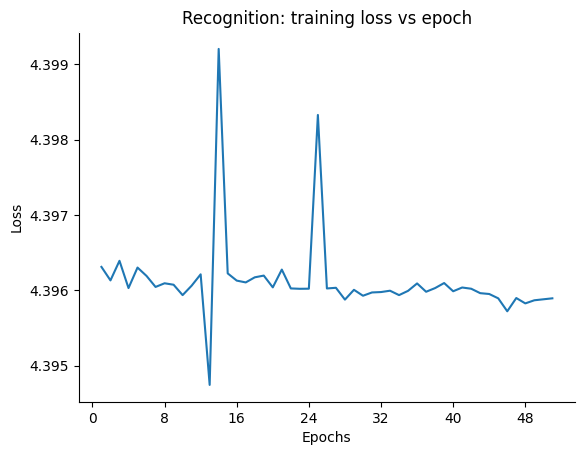

In [71]:
loss_epoch_plot(rec_tr_losses, "Recognition: training loss vs epoch")

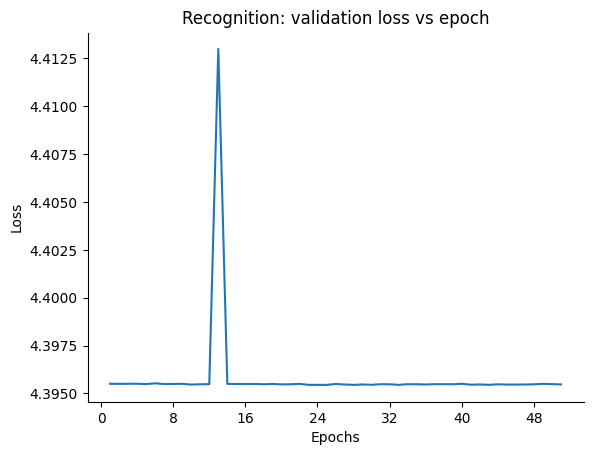

In [72]:
loss_epoch_plot(rec_val_losses, "Recognition: validation loss vs epoch")

### Testing

In [73]:
'''The function that is used to calculate the score in the file CHALL_AGC_FRbasicScript.py'''

def CHALL_AGC_ComputeRecognScores(auto_ids, true_ids):
    #   Compute face recognition score
    #
    #   INPUTS
    #     - AutomSTR: The results of the automatic face
    #     recognition algorithm, stored as an integer
    #
    #     - AGC_Challenge_STR: The ground truth ids
    #
    #   OUTPUT
    #     - FR_score:     The final recognition score
    #
    #   --------------------------------------------------------------------
    #   AGC Challenge
    #   Universitat Pompeu Fabra
    #

    if len(auto_ids) != len(true_ids):
        assert ('Inputs must be of the same len');

    f_beta = 1
    res_list = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nTP = len([i for i in res_list if auto_ids[i] == true_ids[i]])

    res_list = list(filter(lambda x: auto_ids[x] != -1, range(len(auto_ids))))

    nFP = len([i for i in res_list if auto_ids[i] != true_ids[i]])

    res_list_auto_ids = list(filter(lambda x: auto_ids[x] == -1, range(len(auto_ids))))
    res_list_true_ids = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nFN = len(set(res_list_auto_ids).intersection(res_list_true_ids))

    FR_score = (1 + f_beta ** 2) * nTP / ((1 + f_beta ** 2) * nTP + f_beta ** 2 * nFN + nFP)

    return FR_score * 100

In [74]:
predictions_count = {}
expected_count = {}
good = 0
predictions = []
expected = []

predictions_count[-1] = 0
expected_count[-1] = 0

for i in range(1, 81):
    predictions_count[i] = 0
    expected_count[i] = 0

for image_name, id, boundary in rec_train_data:
    with Image.open(images_path + image_name) as image:
        image = image.convert('RGB')
        image = image.crop(boundary)
        if id == 0:
            target = -1
        else:
            target = id
        output = recognition.predict(image)

        predictions_count[output] += 1
        expected_count[target] += 1
        predictions.append(output)
        expected.append(target)

        if output == target:
            good += 1

for key in predictions_count:
    print(f'Identity {key}: Predicted {predictions_count[key]} of {expected_count[key]}')

print('F1-score:', CHALL_AGC_ComputeRecognScores(predictions, expected))

Identity -1: Predicted 0 of 129
Identity 1: Predicted 0 of 13
Identity 2: Predicted 0 of 12
Identity 3: Predicted 0 of 15
Identity 4: Predicted 0 of 13
Identity 5: Predicted 0 of 13
Identity 6: Predicted 0 of 12
Identity 7: Predicted 0 of 12
Identity 8: Predicted 0 of 15
Identity 9: Predicted 0 of 13
Identity 10: Predicted 0 of 11
Identity 11: Predicted 0 of 14
Identity 12: Predicted 0 of 13
Identity 13: Predicted 0 of 13
Identity 14: Predicted 0 of 14
Identity 15: Predicted 0 of 14
Identity 16: Predicted 0 of 14
Identity 17: Predicted 0 of 12
Identity 18: Predicted 0 of 15
Identity 19: Predicted 0 of 12
Identity 20: Predicted 0 of 12
Identity 21: Predicted 0 of 15
Identity 22: Predicted 0 of 15
Identity 23: Predicted 0 of 11
Identity 24: Predicted 0 of 15
Identity 25: Predicted 0 of 13
Identity 26: Predicted 0 of 15
Identity 27: Predicted 0 of 14
Identity 28: Predicted 0 of 12
Identity 29: Predicted 0 of 13
Identity 30: Predicted 0 of 12
Identity 31: Predicted 0 of 13
Identity 32: Pre

### Saving

In [75]:
torch.save(recognition.state_dict(), 'recognition_model.pt')